In [30]:
import os
from dotenv import load_dotenv
from pathlib import Path

NOTEBOOK_PATH = Path().resolve()
dotenv_path = NOTEBOOK_PATH / "postgres.env"
load_dotenv(dotenv_path)

DBHOST = os.environ.get("DBHOST")
DBPORT = os.environ.get("DBPORT")
DBUSER = os.environ.get("DBUSER")
DBNAME = os.environ.get("DBNAME")
DBPASS = os.environ.get("DBPASS")

IMG_DIRECTORY = NOTEBOOK_PATH / "imgs"
IMG_DIRECTORY.mkdir(exist_ok=True)

In [31]:
from sqlalchemy import create_engine, URL

engine_url = URL.create(
    drivername="postgresql+psycopg2",
    username=DBUSER,
    password=DBPASS,
    host=DBHOST,
    port=DBPORT,
    database=DBNAME,
)

engine = create_engine(url=engine_url)

In [32]:
import pandas as pd

query = """
            SELECT 
                p.name,
                p.latitude,
                p.longitude,
                d.year, 
                d.month, 
                d.day, 
                r.amount
            FROM rainfall r
            JOIN places p
            ON p.place_id = r.place_id
            JOIN dates d
            on r.date_id = d.date_id
            ;
        """

df = pd.read_sql(query, engine)

grouped_df = df.groupby(by=["year", "month", "name", "day"]).first()


to_drop = grouped_df[grouped_df.isna().any(axis=1)].index.get_level_values(2).unique()
for name in to_drop:
    grouped_df.drop(name, level='name', inplace=True)


In [33]:
year = 2019
month = 7

idx = pd.IndexSlice
test_df = grouped_df.loc[idx[year, month],].groupby(by=["name"]).agg({"latitude": "first", "longitude": "first", "amount":"sum" })

In [34]:
import geopandas as gpd

ph_shp = gpd.read_file(
    NOTEBOOK_PATH / 
    "raw_files" / 
    "Shapefile" / 
    "PH_Adm2_ProvDists.shp.zip",
    crs="EPSG:4326"
)

query = """
            SELECT *
            FROM grid_shp
            ;
        """
        
intrs = gpd.read_postgis(
    sql=query,
    con=engine,
    geom_col="geometry",
    crs="EPSG:4326"
)

In [35]:
from sklearn.neighbors import KNeighborsRegressor

x = test_df[["longitude", "latitude"]]
y = test_df[["amount"]]

model = KNeighborsRegressor(algorithm="kd_tree", n_neighbors=8, weights="distance").fit(x,y)

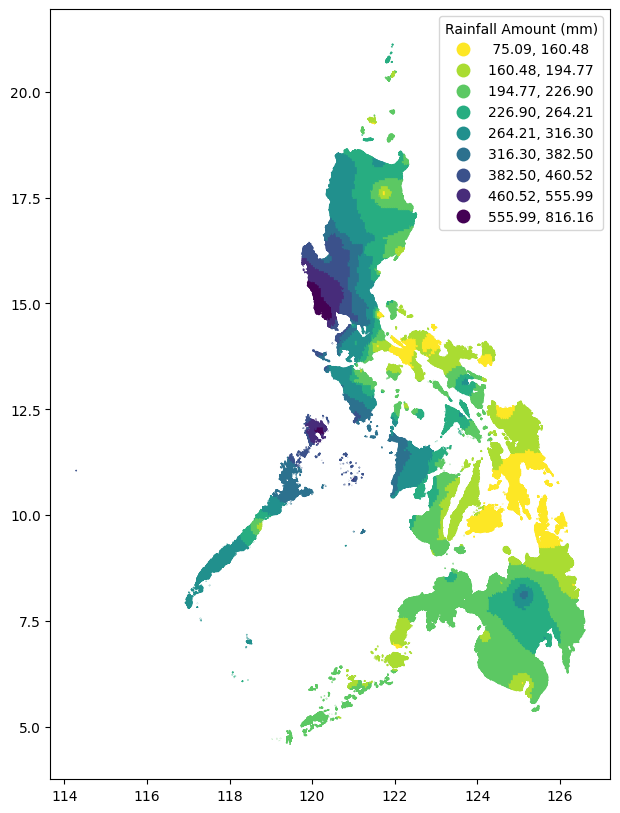

In [36]:
import matplotlib.pyplot as plt

intrs["longitude"] = intrs.apply(lambda row: row["geometry"].centroid.x, axis=1)
intrs["latitude"] = intrs.apply(lambda row: row["geometry"].centroid.y, axis=1)

pred = model.predict(intrs[["longitude", "latitude"]])

intrs["amount"] = pd.Series(pred[:, 0])

ax = intrs.plot(
            column="amount",
            scheme="Natural_Breaks",
            k=9, 
            figsize=(10,10), 
            legend=True,
            legend_kwds={"title": "Rainfall Amount (mm)"},
            edgecolor="face", 
            linewidth=1,
            cmap="viridis_r")

plt.savefig(IMG_DIRECTORY / f"{year}-{month}-rainfall-plot.png")